In [348]:
from numpy import *
import matplotlib.pyplot as plt
from LRFutils import progress
from LRFutils import archive
import analyze
from numba import njit

---

# Config

In [349]:
L = 50 # Size of the grid
D1 = 1e4 # Diffusion coefficient [s-1]
F = 1e4 # linspace(5e-6,1e4,1000,endpoint=True) # Flux [s-1]

N = 0 # L**2 / 100

steps = 1000

---

# Class definition

In [350]:
class Layer:
    def __init__(self, L):
        self.grid = []
        for i in range(L):
            self.grid.append([])
            for j in range(L):
                self.grid[i].append([])
        self.islands = []
    
    def elements(self):
        monomers = []
        islands = []
        for row in self.grid:
            for monomerList in row:
                if monomerList != []:
                    # If the monomer is NOT a part of an islan, it is counted as a monomer
                    if monomerList[0].island is None:
                        monomers += monomerList
    
                    # If the monomer is a part of an islan, it is counted as an island
                    else:
                        if monomerList[0].island not in islands:
                            islands.append(monomerList[0].island)
        return monomers, islands

    def monomers(self):
        return self.elements()[0]

    def islands(self):
        return self.elements()[1]

    def heightmap(self):
        heightmap = zeros((L,L))
        for x in range(L):
            for y in range(L):
                if self.grid[x][y] != []:
                    heightmap[x][y] = len(self.grid[x][y])
        return heightmap

    def corrected_pos(x):
        if x < 0:
            return L-1
        elif x >= L:
            return 0
        else:
            return x

In [351]:
class Island:
    def __init__(self, layer, monomers):
        self.layer = layer
        if type(monomers) is not list: monomers = [monomers] 
        self.monomers = monomers
    
    def add_monomer(self, monomer):
        monomer.island = self
        self.monomers.append(monomer)

In [352]:
class Monomer: 
    def __init__(self, layer, prob=1, x=None, y=None):
        self.layer = layer
        self.island = None
        
        # Place the monomer randomly on the layer
        if x is None:
            self.x = random.randint(0, L)
        else:
            self.x = x
        if y is None:
            self.y = random.randint(0, L)
        else: self.y = y

        # If the place is already occupied, the monomer is a part of the island
        if self.layer.grid[self.x][self.y] != []:
            
            # If the existing monomer is already on an island, the new monomer is a part of this island
            if (island := self.layer.grid[self.x][self.y][0].island) is not None:
                island.add_monomer(self)

            # If the existing monomer is not on an island, a new island is created contining both monomers
            else:
                self.island = Island(self.layer, self)
                self.island.add_monomer(self.layer.grid[self.x][self.y][0])
        
        layer.grid[self.x][self.y].append(self)
    
    def neighbors(self):
        neighbors = []

        if m := self.layer.grid[Layer.corrected_pos(self.x-1)][self.y]:
            neighbors.append(m[0])
        if m := self.layer.grid[Layer.corrected_pos(self.x+1)][self.y]:
            neighbors.append(m[0])
        if m := self.layer.grid[self.x][Layer.corrected_pos(self.y-1)]:
            neighbors.append(m[0])
        if m := self.layer.grid[self.x][Layer.corrected_pos(self.y+1)]:
            neighbors.append(m[0])

        # for x in range(self.x - 1, self.x + 2):
        #     if x < 0: x = L
        #     if x >= L: x = 0
            
        #     for y in range(self.y - 1, self.y + 2):
        #         if y < 0: y = L
        #         if y >= L: y = 0

        #         # Not taking itself
        #         if x != self.x and y != self.y:

        #             # Not taking diagonals
        #             if not (x != self.x and y != self.y):

        #                 # Checking if their is monomers
        #                 if self.layer.grid[x][y] is not None:
        #                     neighbors.append(self.layer.grid[x][y])
                        
        return neighbors

    def islandify(self):
        # Transform the monomer into an island if it has a neighbor
        if len(neighbors := self.neighbors()) != 0:
            islandified = False
            for monomer in neighbors:
                if monomer.island is not None:
                    monomer.island.add_monomer(self)
                    islandified = True
                    break
            if not islandified:
                self.island = Island(self.layer, self)
                for monomer in neighbors:
                    monomer.island = self.island

    def move(self):

        self.islandify()

        if self.island is not None: return

        x, y = self.x, self.y

        d = random.randint(0, 4)
        if d == 0: x -= 1
        elif d == 1: x += 1
        elif d == 2: y -= 1
        elif d == 3: y += 1

        # Apply limit conditions
        x = Layer.corrected_pos(x)
        y = Layer.corrected_pos(y)

        self.layer.grid[self.x][self.y].remove(self)
        self.layer.grid[x][y].append(self)
        self.x, self.y = x, y

        self.islandify()

---
# Simulation

Simulating evolution ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% 1000/1000 0:00:03eta 0:00:00


MovieWriter ffmpeg unavailable; using Pillow instead.


Generating animation ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% 1000/1000 0:00:43eta 0:00:00


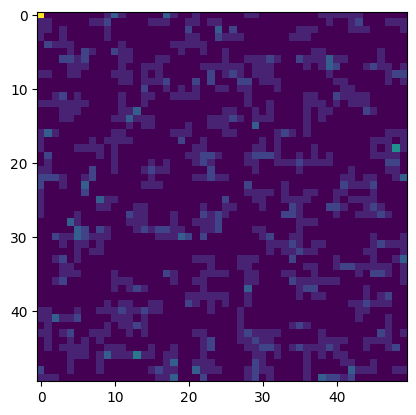

In [353]:
layer = Layer(L)
evolution = []

# Putting monomers on the layer
N=10
while N > 0:
    monomer = Monomer(layer, x=0,y=0)
    N -= 1

def evolve():
    # Creating layer

    for y in range(L):
        for x in range(L):
            if random.random() < F/D1 / L**2:
                Monomer(layer, x=x, y=y)

    for monomer in layer.monomers():
        
        # Move alll monomers
        monomer.move()

        # Check if monomers are in contact -> create island
        if len(neighbors := monomer.neighbors()) > 0:
            island = Island(layer, neighbors + [monomer])

    # Return the new state of the layer as a matrix with 1 if there is a monomer, 0 otherwise
    return layer.heightmap()

# Generating evolution
a = progress.Bar(max=steps, prefix="Simulating evolution")
for i, _ in enumerate(arange(0,steps)):
    evolution.append(evolve())
    a(i+1)

path = archive.new()
analyze.generate_animation(evolution, save_as = f"{path}/Evolution.gif", plot=False, verbose = False)